# 0.0. IMPORTS

In [1]:
# Importando pandas e a classe inflection (para organizar os nomes das colunas)
# Importando também numpy para tratar números, seaborn e matplotlib para visualization
%matplotlib inline
import matplotlib.pyplot as plt
import pandas  as pd
import numpy   as np
import seaborn as sns

import math
import inflection
import datetime

from IPython.core.display import HTML
from IPython.display import Image

# Corrigir o tamanho dos gráficos pequenos
plt.rcParams['figure.figsize'] = [30, 20]

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
# Lendo os arquivos CSV utilizando parametro low_memory que ajuda PC's com baixa memória a carregar grandes arquivos
# Se low_memory = False, então ele irá carregar todo o arquivo de uma vez, do contrário carregaria em partes
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Juntando os dois DF's, utilizando "left join" e a coluna "Store" como PK, esta coluna está presente em ambos DF's

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 -  DESCRICAO DOS DADOS

In [3]:
#Criando um DF de cópia de segurança
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
# Guardando as antigas colunas em uma variável para trata-las posteriormente

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# utilizando uma função snakecase que chama a função lambda para chamar o inflection e transformar as colunas em minusculo
# separado por underline _

snakecase = lambda x: inflection.underscore( x )


# função map mapeia tudo da snakecase e pega a lista cols_old guardando a nova lista na variável cols_new
cols_new = list( map( snakecase, cols_old ) )

# passando as colunas cols_new para o DF1
df1.columns =  cols_new

## 1.2. Data Dimensions

In [5]:
# Apenas printa a quantidade de linhas e coluna do DF
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [6]:
# Tipos de dados em cada coluna do DF
# Observando a coluna Date que é um Object (Object = string no pandas, tudo que não for INT o pandas transforma em Object)
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
# Utilizando a função to_datetime para converter a coluna date para datetime
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [8]:
# Checando se possui alguma coluna com linha vazia e somando o total em cada coluna

# existem 3 formas de tratar NA
#   1- Eliminar as linhas que possuem NA
#   2- Usar algoritmo de ML para completar esses NA
#   3- Entendendo do negócio para saber o motivo das linhas estarem faltando

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
## aplicando função lambda para aplicar um valor em tudo que é NA e deixar o valor atual nos que possuem algum valor
## Foi feito desta forma pois considera-se que se o concorrente está muito longe, não existe concorrencia, então
## colocou-se um valor muito grande (maior que o máximo existente)
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

## aplicando novamente a função lambda para transferir o valor da coluna date para a as colunas da data de abertura
## dos concorrentes, assim os algoritmos de ML podem utilizar a função para calcular tempos de datas
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

## Mesma lógica do competition_open_since_year, aplicando a data nas linhas NA para poder abastecer futuramente
## os algoritmos de ML
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


## Foi criado um dicionario com os meses, transformando as linhas com NA em 0, inserindo o nome do mês na nova coluna
## chamada month_map de acordo com o nome especificado no dicionário e usando a função lambada, passamos pelas linhas
## inserindo 1 quando o mes da coluna date estiver presente na coluna promo_interval e 0 caso não tenha o mês
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)
             
df1['month_map'] = df1['date'].dt.month.map( month_map )
             
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

In [10]:
# 5 exemplos exibindo em Tabela
df1.sample(5).T

,40654,539195,272628,271689,515483
store,515,321,862,856,24
day_of_week,4,3,7,1,3
date,2015-06-25 00:00:00,2014-03-05 00:00:00,2014-11-23 00:00:00,2014-11-24 00:00:00,2014-03-26 00:00:00
sales,7637,6846,0,9184,6412
customers,673,622,0,1139,650
open,1,1,0,1,1
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,a,a,a


In [11]:
#Total de NA ou NaN em cada coluna
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [12]:
#Conferindo novamente os tipos de cada coluna
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
# Convertendo as colunas que estão em float (decimal) para int64 assim como o restante do DF

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( "int64" )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( "int64" )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( "int64" )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( "int64" )

In [14]:
# Checando se as conversões foram feitas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [16]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
812725,676,3,6578,1584,1,1,0,1410.0,9,2008,0,27,2013,0
707709,470,6,13447,1959,1,0,0,50.0,10,2013,0,40,2013,0
477064,630,3,9241,1029,1,1,1,1690.0,4,2015,0,18,2014,0
625254,525,3,13879,1010,1,1,0,1870.0,9,2013,0,51,2013,0
370645,674,7,0,0,0,0,0,2640.0,12,2005,1,31,2013,1


In [17]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
81620,0,a,a,0,May
156276,0,a,a,"Feb,May,Aug,Nov",Mar
719322,0,a,c,0,Set
640957,0,d,c,0,Dec
376515,0,d,c,0,Aug


### 1.7.1. Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [19]:
# min = valor mínimo da coluna
# max = valor máximo da coluna
# range = diferença entre mínimo e máximo
# mean = MÉDIA da coluna
# median = 
# std = desvio padrão, pode ser interpretada como margem de erro, std = 100 de uma mean = 300 significa que o valor é entre 200 a 400
# skew = 
# kurtosis = 

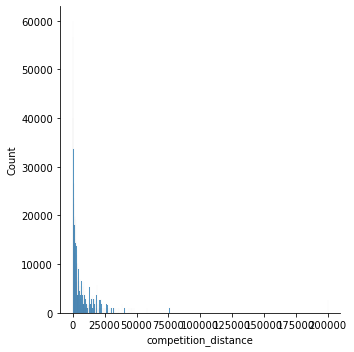

In [20]:
sns.displot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [21]:
# Pegar quantidade de valores únicos em cada coluna
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

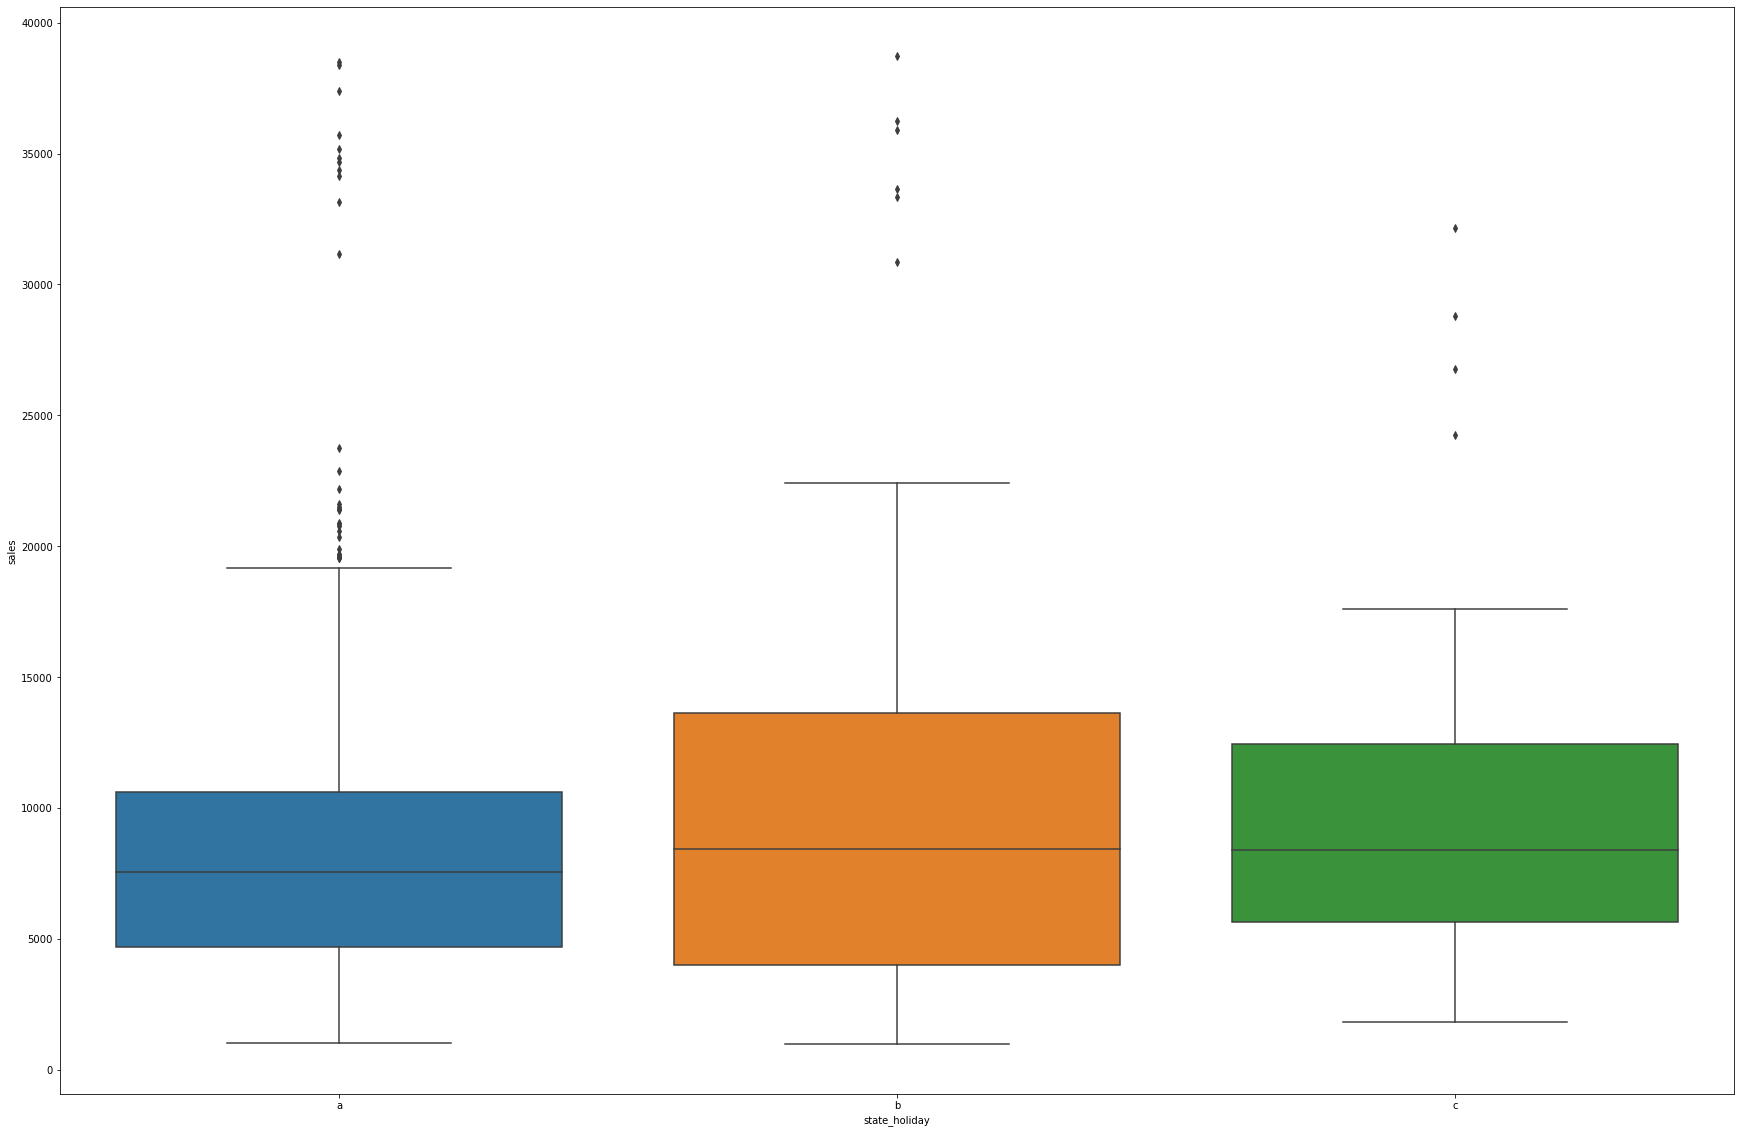

In [22]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

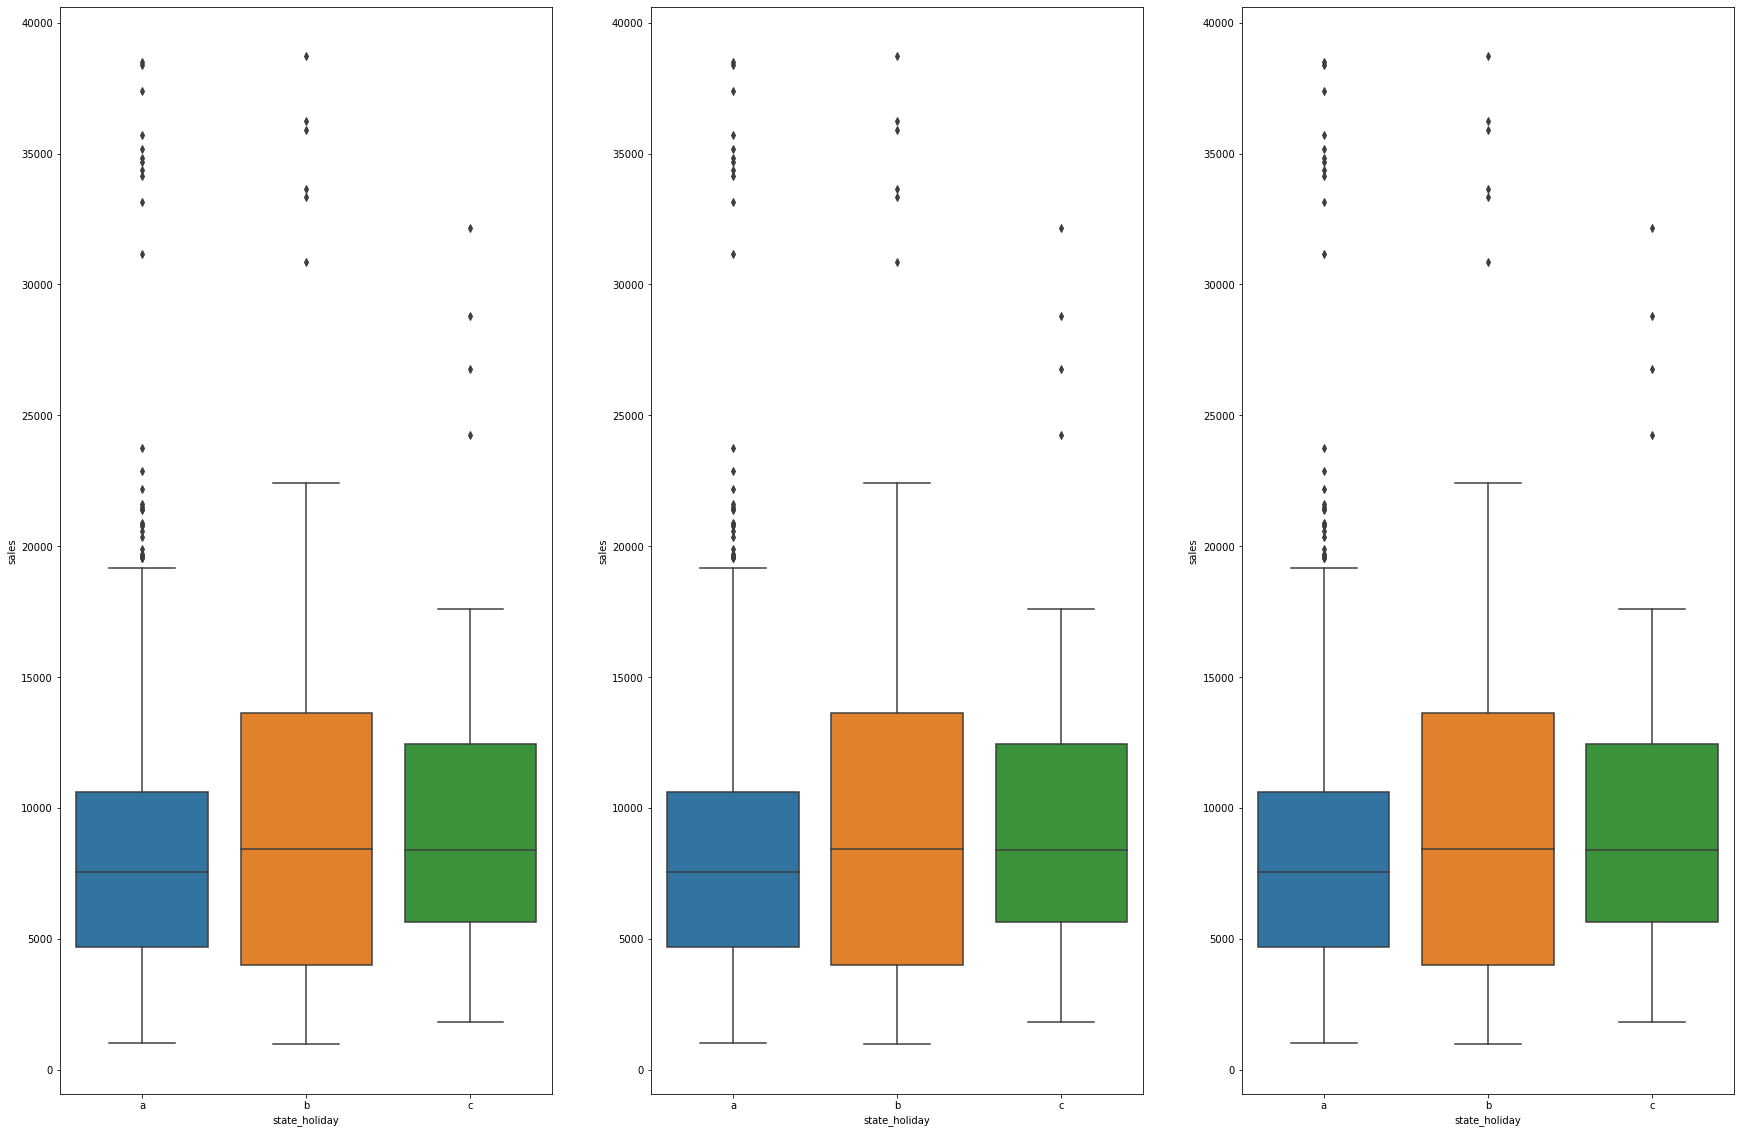

In [23]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

In [24]:
# Descrevendo o boxplot
## A barra mais embaixo significa o menor valor da coluna, enquanto a barra em cima é o maior valor
## No quadrado, o canto inferior é o valor na posição de número 25 enquanto a linha do meio é o 50 e a parte superior do
## quadrado é a posição de número 75
## os pontos pretos são os outliners


# Pesquisar mais sobre boxplot

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [34]:
# Criando uma cópia de segurança no dataframe
df2 = df1.copy()

## 2.1. Mapa Mental de Hipótesis

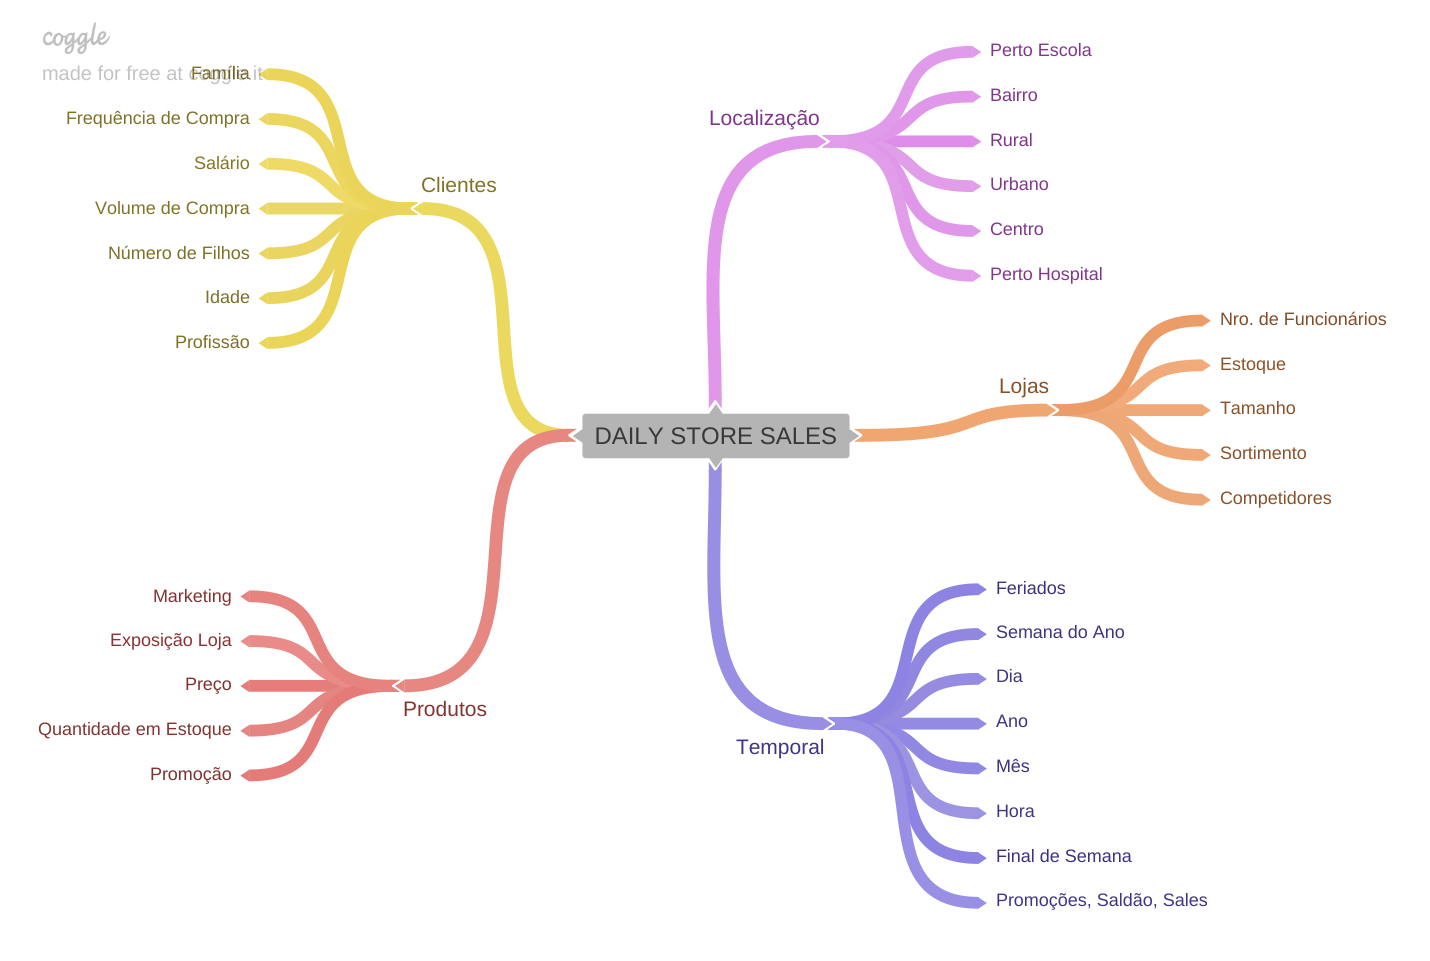

In [26]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação de Hipóteses

### 2.2.1. Hipoteses Loja 

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [27]:
# Criado uma coluna com o ano
df2['year'] = df2['date'].dt.year

# Criando uma colunai com o mes
df2['month'] = df2['date'].dt.month

# Criando uma coluna com o dia
df2['day'] = df2['date'].dt.day

# Criando uma coluna com o numero da semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Criando uma coluna com ano-semana
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Criando uma coluna com a junção do ano e mes, pois estavam separados utilizando sempre o dia 1 de cada mês
# Criando outra coluna com a qtde de meses que existe uma competição próxima
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# Criando uma coluna para juntar as informações de data inicial da promoção
# e outra coluna para contar quantas semanas a promoção está ativa
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days  ).astype( int ) 

# Melhorando os valores da coluna assortment para facilitar a leitura
df2['assortment'] =  df2['assortment'].apply( lambda x: 'basic' if x ==  'a' else 'extra' if x == 'b' else 'extended' )

# Melhorando os valores da coluna state_holiday para facilitar a leitura
df2['state_holiday'] =  df2['state_holiday'].apply( lambda x: 'public_holiday' if x ==  'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [ ]:
# Método Head com transpose para verificar as alterações
df2.head().T

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS 

In [29]:
# Criando um cópia de segurança
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Lihas 

In [35]:
# Selecionando apenas linhas de lojas que estavam abertas e tiveram alguma venda
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

KeyError: 'open'

## 3.2. Seleção das Colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')